## Importación de librerías

In [1]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## SpaCy en Ingles

### Instalación

In [ ]:
# Instalar modelo de spaCy en inglés
!python -m spacy download en_core_web_sm

### Carga del modelo

In [2]:
# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

## Dataset

### Carga y renombre de columnas

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento", "Unnamed: 0": "ID"})

### Datos únicos en columna "sentimiento"

In [4]:
df.sentimiento.unique()

array(['FAKE', 'REAL'], dtype=object)

### Seteo de columna "ID" como indice

In [5]:
df = df.set_index('ID')

### Columnas y filas

In [6]:
df.shape

(6335, 3)

### Primeros registros

In [7]:
df.head()

,title,texto,sentimiento
ID,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Distribución del dataset

In [8]:
q_balance = df['sentimiento'].value_counts()
p_balance = (df['sentimiento'].value_counts(normalize=True)*100).round(2)
print("Cantidad del balance del dataset: \n" + str(q_balance))
print("\n\n")
print("Proporcion del balance del dataset: \n" + str(p_balance))

Cantidad del balance del dataset: 
sentimiento
REAL    3171
FAKE    3164
Name: count, dtype: int64



Proporcion del balance del dataset: 
sentimiento
REAL    50.06
FAKE    49.94
Name: proportion, dtype: float64


## Desafío 01: Balance

In [9]:
### DESAFIO:
# Está balanceado? Cómo lo arreglarìas sino?

### COMENTARIOS:
# El dataset se encuentra balanceado, por lo cual no es necesario aplicar alguna tecnica de balanceo.
# En el caso de haberla necesitado, se podria haber aplicado SMOTE o ADASYN.

## Desafío 02: Variables

In [10]:
### PREGUNTA:
# En término de variable que diferencias encuentras con los que usabas en Machine Learning?

### COMENTARIOS:
# Considerando la menor cantidad de columnas, se puede decir que el dataset es más simple que los utilizados en Machine Learning.
# Pero en este caso, las variables para analizar son textos que se dividiran en partes, por lo que se puede decir que es más complejo.

## Desafío 03: Dimensionado

In [11]:
### DESAFIO:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
# Las clases quedaron balanceadas?

### COMENTARIOS:
# Se cortó el dataset a 1000 registros, por lo que se puede decir que se redujo a un número manejable para el procesamiento.
# Las clases siguen balanceadas debido a que se utilizó el parámetro stratify con la variable objetivo.

In [17]:
# Dimensiona el dataset ** USANDO TRAIN_TEST_SPLIT **
df_reducido, df_restante = train_test_split(df, train_size=1000, stratify=df['sentimiento'], random_state=42)

In [18]:
# Resultados
print("Balance original:")
print((df['sentimiento'].value_counts(normalize=True)*100).round(2))

print("\nBalance de la reducción:")
print((df_reducido['sentimiento'].value_counts(normalize=True)*100).round(2))

print("\nRegistros y columnas:")
print(df_reducido.shape)

Balance original:
sentimiento
REAL    50.06
FAKE    49.94
Name: proportion, dtype: float64

Balance de la reducción:
sentimiento
REAL    50.1
FAKE    49.9
Name: proportion, dtype: float64

Registros y columnas:
(1000, 3)


## Desafío 04: Etiquetas

In [12]:
### DESAFIO:
# Ajustar etiquetas de sentimiento (0 = fake, 1 = real)

### COMENTARIOS:
# Por medio de una funcion lambda se ajustaron las etiquetas de sentimiento, donde si el valor es 'FAKE' se cambia a 0 y si es 'REAL' se cambia a 1.

In [ ]:
# Aplicación de la función lambda
df_reducido['sentimiento'] = df_reducido['sentimiento'].apply(lambda x: 0 if x == 'FAKE' else 1)

## Funciones para procesar el dataset

### Tokenizar, eliminar stopwords, lematizar y eliminar caracteres especiales

In [13]:
def preprocesar_texto(texto):
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return " ".join(tokens)

### Análisis de n-grams

In [14]:
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

### Graficar n-gramas

In [15]:
def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis', hue="N-gram", legend=False)
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

## Procesando el dataset

### Prepocesar el texto

In [19]:
df_reducido["texto_procesado"] = df_reducido["texto"].apply(preprocesar_texto)

### WordCloud

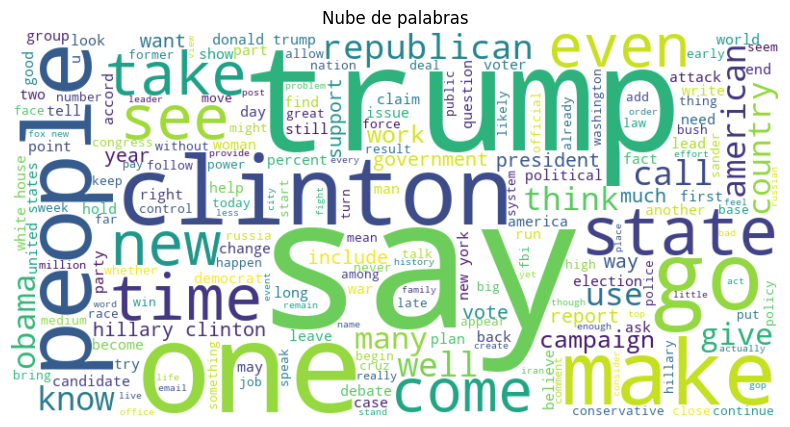

In [ ]:
text_combined = " ".join(df_reducido['texto_procesado'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

### N-grams (unigramas, bigramas, trigramas y cuatrigramas)

Unigramas más comunes:
    N-gram  Frecuencia
0      say        4803
1    trump        3664
2  clinton        2863
3    would        2104
4    state        2009
5      one        1907
6   people        1676
7       go        1610
8     year        1596
9     make        1580


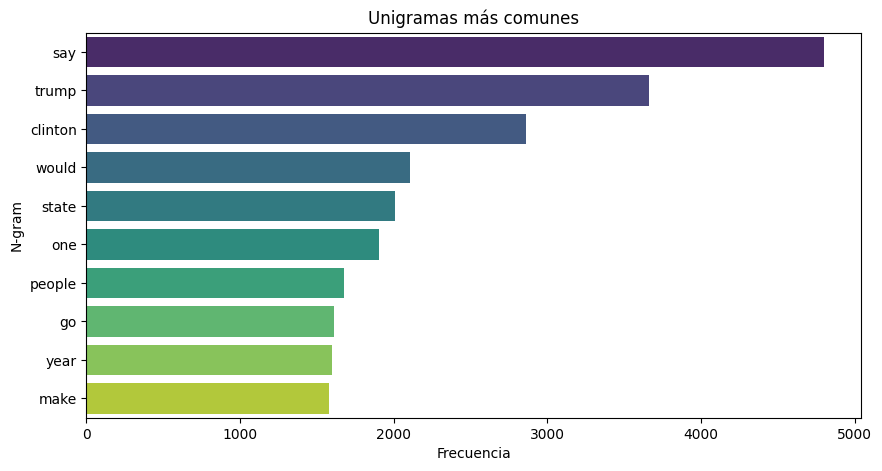


Bigramas más comunes:
            N-gram  Frecuencia
0  hillary clinton         695
1     donald trump         590
2      white house         455
3         new york         438
4    united states         431
5         fox news         255
6  president obama         222
7  secretary state         189
8    new hampshire         185
9   foreign policy         174


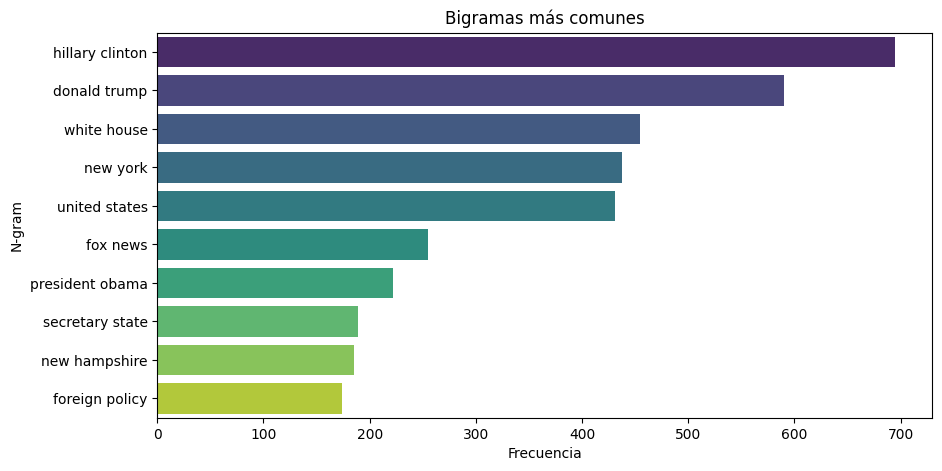


Trigramas más comunes:
                              N-gram  Frecuencia
0                     new york times         134
1                     case case case          64
2             president barack obama          64
3                       sen ted cruz          44
4             former secretary state          43
5                wall street journal          43
6            president united states          42
7  republican presidential candidate          40
8                    sen marco rubio          40
9               director james comey          34


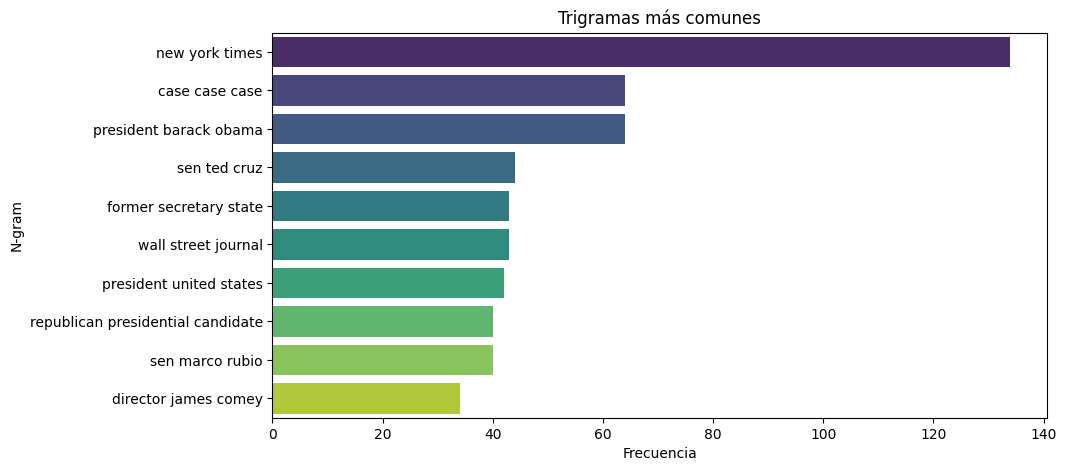


Cuatrigramas más comunes:
                               N-gram  Frecuencia
0                 case case case case          63
1            fbi director james comey          32
2           jersey gov chris christie          23
3                new jersey gov chris          23
4    russian president vladimir putin          23
5                ohio gov john kasich          22
6  associated press contribute report          20
7     secretary state hillary clinton          20
8            use private email server          20
9      attorney general loretta lynch          19


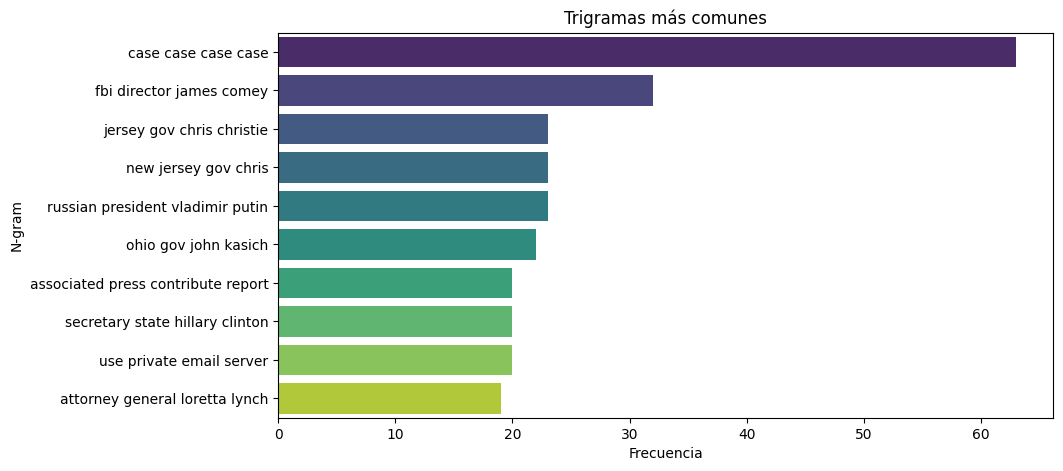

In [22]:
unigrams = get_top_ngrams(df_reducido['texto_procesado'], 1)
bigrams = get_top_ngrams(df_reducido['texto_procesado'], 2)
trigrams = get_top_ngrams(df_reducido['texto_procesado'], 3)
cuatrigrams = get_top_ngrams(df_reducido['texto_procesado'], 4)

print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")

print("\nBigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")

print("\nTrigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

print("\nCuatrigramas más comunes:")
print(cuatrigrams)
plot_ngrams(cuatrigrams, "Trigramas más comunes")

## Entrenamiento

### Separación del dataset

In [23]:
X = df_reducido['texto_procesado'] # Variable independiente
y = df_reducido['sentimiento'] # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Pipeline para "TfidfVectorizer" y "MultinomialNB"

In [24]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

### Aplicando pipeline para entrenar el modelo y prediciendo

In [25]:
# Entrenando
pipeline.fit(X_train, y_train)

# Prediciendo
y_pred = pipeline.predict(X_test)

### Evaluando el modelo

In [26]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.73
              precision    recall  f1-score   support

        FAKE       0.96      0.48      0.64       100
        REAL       0.65      0.98      0.78       100

    accuracy                           0.73       200
   macro avg       0.81      0.73      0.71       200
weighted avg       0.81      0.73      0.71       200



## Optimización

### Transformando a "TfidfVectorizer" con hiperparámetros

In [27]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

### Entrenando a "PassiveAggressiveClassifier" y prediciendo

In [31]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)

# Entrenando
pac.fit(tfidf_train,y_train)

# Prediciendo
y_pred2 = pac.predict(tfidf_test)

### Evaluando el modelo

In [33]:
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.875
              precision    recall  f1-score   support

        FAKE       0.88      0.87      0.87       100
        REAL       0.87      0.88      0.88       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.87       200
weighted avg       0.88      0.88      0.87       200

